In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from rasterio.merge import merge
import glob

from rasterio.plot import adjust_band
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image
import rasterio.features
import rasterio.warp
import rasterio.mask
from rasterio.merge import merge
import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras.models import load_model

from skimage.transform import resize

In [2]:
#ensure size of tile is uniform, and reshape the numpy into a image format then normalize
def newXpreprocessing(tile,layers,width,height):
    #print(tile.shape,"before")
    tile = resize(tile, (layers,width,height))
    #print(tile.shape,"resize")
    tile = reshape_as_image(tile)
    #print(tile.shape,"reshape")
    #normalising tile
    tile = tile/255
    return tile

In [3]:
#Keras compatible preditor - works tif. Each image is predicted against and then saved as a colour representing the prediction
# to be turned into a mosaic at the next step
def predictingNewX(model,data_dir_list,data_path,width=40,height=40,layers=3):
    #load list of image names in each category
    img_list = os.listdir(os.path.join(data_path))
     #   print ('Loading the images for prediction -'+'{}\n'.format(dataset))
    num_img_files = len(img_list) 

    for i in range(num_img_files):
        img_name = img_list[i]
        img_filename = os.path.join(data_path,img_name)
        #model expects image formatted a certain way
        X_new = []
        with rasterio.open(img_filename) as ds:
            tile=ds.read()
            #preprocess tille according to model expectations
            pre_tile=newXpreprocessing(tile,layers,width,height)

        # Add tile to array
        X_new.append(pre_tile)
        # Make sure they're numpy arrays (as opposed to lists)
        X_new = np.array(X_new)
        #make prediction against X-new array
        #yNew = model.predict_classes(X_new)
        yNew = model.predict(X_new)
        #classes_y=np.argmax(yNew,axis=1)
        #Transposed value to get easy access to prediction for 1 (prospectable)
        yNewT = yNew.T
        print(yNewT[1])
        y_classes = float(yNewT[1])
        #determine colour of class of interest
        class_image = loadClassTile(y_classes,class_path)
        with rasterio.open(
            str(output_path) +'\\' + str(i) +'_y.tif',
            'w',
            driver='GTiff',
            height=class_image.shape[1],
            width=class_image.shape[2],
            count=class_image.shape[0],
            dtype=class_image.dtype,
            class_image=ds.crs,
            nodata=None,
            transform=ds.transform
            ) as dst:
            dst.write(class_image)
        print('processed: '+ str(i) +'_y.tif')


In [4]:
#Method to replace a detected class with a single colour image representing that class. 
def loadClassTile(yNew,class_path):
    if  yNew >= 0.99:
        classlabel = '99.tiff'
    elif yNew >= 0.98:
        classlabel = '98.tiff'
    elif yNew >= 0.97:
        classlabel = '97.tiff'  
    elif yNew >= 0.96:
        classlabel = '96.tiff'  
    elif yNew >= 0.95:
        classlabel = '95.tiff'
    elif yNew >= 0.94:
        classlabel = '94.tiff'
    elif yNew >= 0.93:
        classlabel = '93.tiff'
    elif yNew >= 0.92:
        classlabel = '92.tiff'
    elif yNew >= 0.91:
        classlabel = '91.tiff'
    elif yNew >= 0.90:
        classlabel = '90.tiff'
    elif yNew >= 0.85:
        classlabel = '85.tiff'
    elif yNew >= 0.80:
        classlabel = '80.tiff'
    elif yNew >= 0.70:
        classlabel = '70.tiff'
    elif yNew >= 0.60:
        classlabel = '60.tiff'
    elif yNew >= 0.50:
        classlabel = '50.tiff'
    elif yNew >= 0:
        classlabel = '0.tiff'
    else:
        classlabel = 'error.tiff'
    
    with rasterio.open(str(class_path) + '\\' + classlabel) as cs:
        class_image=cs.read()
    return class_image
    

In [5]:
# https://gis.stackexchange.com/questions/348925/merging-rasters-with-rasterio-in-blocks-to-avoid-memoryerror
# https://rasterio.readthedocs.io/en/latest/api/rasterio.merge.html
# https://automating-gis-processes.github.io/CSC18/lessons/L6/raster-mosaic.html

# this script is performed in memory and is thus memroy intensive TO DO: create a rasterio-in-blocks implementation
#a folder is created containig the class images(with CRS), all images within this folder are mosaiced together into a single raster 
def merge_raster_in_folder(src_dir, dest_dir):
    """Merge all the raster (TIFF extension) within the given directory"""
    #simple merges outputs from model and merges them
    #src_dir = r"C:\Data\Test_dataset"
    out_fp = dest_dir + r"\Drone_prediction.tif"
    # create list of raster files in source folder
    src_files_to_mosaic = []
    os.chdir(src_dir)
    for file in glob.glob("*.tif"):
        src = rasterio.open(file)
        src_files_to_mosaic.append(file)

    # create list of raster objects from the list of raster filename
    sources = [rasterio.open(raster) for raster in src_files_to_mosaic]

    # create array representing all source rasters mosaicked together
    mosaic, out_transform = merge(sources)
    #checkl mosaic is created 
    show(mosaic, cmap='terrain')

    out_meta = src.meta.copy()
    out_meta.update({"driver":"GTiff",
                     "height":mosaic.shape[1],
                     "width":mosaic.shape[2],
                     "transform":out_transform,
                     "crs":'+proj=latlong' #TO DO: Pass in CRS
    }
    )
    with rasterio.open(out_fp, "w", **out_meta) as dest:
        dest.write(mosaic)

In [6]:
#declare path directories
data_path = r'C:\Data\Predict2'
output_path = r'C:\Data\output'
class_path = r'C:\Data\ClassesPredict'
result_path = r'C:\Data'
data_dir_list = os.listdir(data_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 83, 83, 64)        4096      
                                                                 
 batch_normalization (BatchN  (None, 83, 83, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 83, 83, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 41, 41, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 41, 41, 64)        0         
                                                                 
 flatten (Flatten)           (None, 107584)            0

C:\Users\Gavin\.conda\envs\Rasterio3_P3_7\lib\site-packages\rasterio\__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


processed: 0_y.tif
[0.0668927]
processed: 1_y.tif
[0.00378131]
processed: 2_y.tif
[0.00158685]
processed: 3_y.tif
[0.9337574]
processed: 4_y.tif
[0.01734471]
processed: 5_y.tif
[3.8873978e-12]
processed: 6_y.tif
[0.08454765]
processed: 7_y.tif
[0.01174831]
processed: 8_y.tif
[0.3500417]
processed: 9_y.tif
[0.6389266]
processed: 10_y.tif
[0.7795934]
processed: 11_y.tif
[0.9551272]
processed: 12_y.tif
[5.2614232e-05]
processed: 13_y.tif
[0.5681267]
processed: 14_y.tif
[0.5323099]
processed: 15_y.tif
[0.16304977]
processed: 16_y.tif
[0.26581085]
processed: 17_y.tif
[0.6389266]
processed: 18_y.tif
[0.1125609]
processed: 19_y.tif
[0.8556045]
processed: 20_y.tif
[0.7684765]
processed: 21_y.tif
[6.701219e-05]
processed: 22_y.tif
[0.51863945]
processed: 23_y.tif
[0.6879122]
processed: 24_y.tif
[0.05648642]
processed: 25_y.tif
[0.02188772]
processed: 26_y.tif
[0.05039455]
processed: 27_y.tif
[0.05887281]
processed: 28_y.tif
[8.047799e-05]
processed: 29_y.tif
[0.27827618]
processed: 30_y.tif
[0.

[9.181397e-06]
processed: 241_y.tif
[7.4309006e-05]
processed: 242_y.tif
[3.6533547e-05]
processed: 243_y.tif
[0.00175864]
processed: 244_y.tif
[0.01334136]
processed: 245_y.tif
[1.7970926e-06]
processed: 246_y.tif
[4.5947614e-05]
processed: 247_y.tif
[7.9367986e-08]
processed: 248_y.tif
[2.4439963e-05]
processed: 249_y.tif
[0.00941666]
processed: 250_y.tif
[0.00278188]
processed: 251_y.tif
[1.3977148e-05]
processed: 252_y.tif
[0.1263891]
processed: 253_y.tif
[0.01909881]
processed: 254_y.tif
[1.5699223e-06]
processed: 255_y.tif
[1.2396542e-07]
processed: 256_y.tif
[8.7021995e-08]
processed: 257_y.tif
[1.8465084e-07]
processed: 258_y.tif
[4.515038e-07]
processed: 259_y.tif
[0.00020554]
processed: 260_y.tif
[4.718309e-07]
processed: 261_y.tif
[0.0004646]
processed: 262_y.tif
[5.553019e-07]
processed: 263_y.tif
[2.1609101e-05]
processed: 264_y.tif
[1.3183286e-06]
processed: 265_y.tif
[1.1945795e-05]
processed: 266_y.tif
[3.7192767e-09]
processed: 267_y.tif
[1.9326511e-05]
processed: 268_

[0.92736745]
processed: 474_y.tif
[0.999853]
processed: 475_y.tif
[0.9990038]
processed: 476_y.tif
[0.9990646]
processed: 477_y.tif
[0.84836125]
processed: 478_y.tif
[0.97188795]
processed: 479_y.tif
[0.9996731]
processed: 480_y.tif
[0.9984315]
processed: 481_y.tif
[0.99979943]
processed: 482_y.tif
[0.9304551]
processed: 483_y.tif
[0.6826552]
processed: 484_y.tif
[0.9968419]
processed: 485_y.tif
[0.99971133]
processed: 486_y.tif
[0.9840771]
processed: 487_y.tif
[0.99955636]
processed: 488_y.tif
[0.9958347]
processed: 489_y.tif
[0.9998816]
processed: 490_y.tif
[0.95489734]
processed: 491_y.tif
[0.99856645]
processed: 492_y.tif
[0.9999927]
processed: 493_y.tif
[0.9993383]
processed: 494_y.tif
[0.99999106]
processed: 495_y.tif
[0.6911692]
processed: 496_y.tif
[0.73523235]
processed: 497_y.tif
[0.9999919]
processed: 498_y.tif
[0.99826753]
processed: 499_y.tif
[0.83147085]
processed: 500_y.tif
[0.98220235]
processed: 501_y.tif
[0.9866101]
processed: 502_y.tif
[0.96763045]
processed: 503_y.t

[0.9999927]
processed: 721_y.tif
[0.9997031]
processed: 722_y.tif
[0.9995721]
processed: 723_y.tif
[0.99789375]
processed: 724_y.tif
[0.997442]
processed: 725_y.tif
[0.9994461]
processed: 726_y.tif
[0.99995303]
processed: 727_y.tif
[0.99986184]
processed: 728_y.tif
[0.9983669]
processed: 729_y.tif
[0.9987753]
processed: 730_y.tif
[0.96695966]
processed: 731_y.tif
[0.9997845]
processed: 732_y.tif
[0.9810874]
processed: 733_y.tif
[0.9020197]
processed: 734_y.tif
[0.7073531]
processed: 735_y.tif
[0.9992151]
processed: 736_y.tif
[0.83674407]
processed: 737_y.tif
[0.9837661]
processed: 738_y.tif
[0.99552935]
processed: 739_y.tif
[0.9985563]
processed: 740_y.tif
[0.9990669]
processed: 741_y.tif
[0.0045892]
processed: 742_y.tif
[0.47921693]
processed: 743_y.tif
[0.8596461]
processed: 744_y.tif
[0.7557375]
processed: 745_y.tif
[0.99963796]
processed: 746_y.tif
[0.99784505]
processed: 747_y.tif
[0.9971674]
processed: 748_y.tif
[0.16926092]
processed: 749_y.tif
[0.9261704]
processed: 750_y.tif
[

processed: 967_y.tif
[0.9839336]
processed: 968_y.tif
[0.9993581]
processed: 969_y.tif
[0.99998355]
processed: 970_y.tif
[0.99370146]
processed: 971_y.tif
[0.9833233]
processed: 972_y.tif
[0.9999976]
processed: 973_y.tif
[0.9997534]
processed: 974_y.tif
[0.99898404]
processed: 975_y.tif
[0.9997985]
processed: 976_y.tif
[0.9992725]
processed: 977_y.tif
[0.9970933]
processed: 978_y.tif
[0.9996662]
processed: 979_y.tif
[0.99944764]
processed: 980_y.tif
[0.99177176]
processed: 981_y.tif
[0.9981055]
processed: 982_y.tif
[0.9999937]
processed: 983_y.tif
[0.99741095]
processed: 984_y.tif
[0.9996389]
processed: 985_y.tif
[0.999972]
processed: 986_y.tif
[0.9983467]
processed: 987_y.tif
[0.95548034]
processed: 988_y.tif
[0.9955688]
processed: 989_y.tif
[0.99824166]
processed: 990_y.tif
[0.99118876]
processed: 991_y.tif
[0.99992]
processed: 992_y.tif
[0.9896896]
processed: 993_y.tif
[0.9999119]
processed: 994_y.tif
[0.9988041]
processed: 995_y.tif
[0.82031035]
processed: 996_y.tif
[0.9767461]
pro

processed: 1208_y.tif
[0.7233892]
processed: 1209_y.tif
[0.99543625]
processed: 1210_y.tif
[0.90338576]
processed: 1211_y.tif
[0.5370448]
processed: 1212_y.tif
[0.9924534]
processed: 1213_y.tif
[0.99944216]
processed: 1214_y.tif
[0.9991405]
processed: 1215_y.tif
[0.6389266]
processed: 1216_y.tif
[0.99827075]
processed: 1217_y.tif
[0.9623444]
processed: 1218_y.tif
[0.89604294]
processed: 1219_y.tif
[0.8795838]
processed: 1220_y.tif
[0.94294983]
processed: 1221_y.tif
[0.98911417]
processed: 1222_y.tif
[0.96606565]
processed: 1223_y.tif
[0.99992776]
processed: 1224_y.tif
[0.974026]
processed: 1225_y.tif
[0.91422904]
processed: 1226_y.tif
[0.9799944]
processed: 1227_y.tif
[0.72507524]
processed: 1228_y.tif
[0.6389266]
processed: 1229_y.tif
[0.9901524]
processed: 1230_y.tif
[0.9951526]
processed: 1231_y.tif
[0.6389266]
processed: 1232_y.tif
[0.99998915]
processed: 1233_y.tif
[0.6389266]
processed: 1234_y.tif
[0.982631]
processed: 1235_y.tif
[0.10395303]
processed: 1236_y.tif
[0.6389266]
pro

processed: 1442_y.tif
[1.8932887e-26]
processed: 1443_y.tif
[6.2830035e-16]
processed: 1444_y.tif
[2.8532635e-27]
processed: 1445_y.tif
[1.4485455e-37]
processed: 1446_y.tif
[5.677419e-21]
processed: 1447_y.tif
[2.4618892e-29]
processed: 1448_y.tif
[3.6865442e-26]
processed: 1449_y.tif
[2.643919e-17]
processed: 1450_y.tif
[3.805201e-22]
processed: 1451_y.tif
[1.9640017e-11]
processed: 1452_y.tif
[2.840139e-24]
processed: 1453_y.tif
[5.4168e-25]
processed: 1454_y.tif
[8.506928e-22]
processed: 1455_y.tif
[1.8022616e-12]
processed: 1456_y.tif
[2.8671157e-30]
processed: 1457_y.tif
[6.69315e-23]
processed: 1458_y.tif
[1.7433136e-12]
processed: 1459_y.tif
[4.0964747e-28]
processed: 1460_y.tif
[2.0867157e-31]
processed: 1461_y.tif
[0.]
processed: 1462_y.tif
[1.9708792e-27]
processed: 1463_y.tif
[2.554163e-16]
processed: 1464_y.tif
[4.5670104e-17]
processed: 1465_y.tif
[2.1295848e-32]
processed: 1466_y.tif
[9.54496e-20]
processed: 1467_y.tif
[3.2526484e-31]
processed: 1468_y.tif
[2.6804e-22]
p

[0.06364496]
processed: 1667_y.tif
[0.28338176]
processed: 1668_y.tif
[0.01974767]
processed: 1669_y.tif
[0.02810891]
processed: 1670_y.tif
[0.110838]
processed: 1671_y.tif
[0.09686575]
processed: 1672_y.tif
[0.0748613]
processed: 1673_y.tif
[0.07634798]
processed: 1674_y.tif
[0.0086559]
processed: 1675_y.tif
[0.06128608]
processed: 1676_y.tif
[0.00293307]
processed: 1677_y.tif
[0.0143887]
processed: 1678_y.tif
[0.07826094]
processed: 1679_y.tif
[0.02528191]
processed: 1680_y.tif
[0.00612489]
processed: 1681_y.tif
[0.11748014]
processed: 1682_y.tif
[0.06938978]
processed: 1683_y.tif
[0.00322863]
processed: 1684_y.tif
[0.00162539]
processed: 1685_y.tif
[0.02247819]
processed: 1686_y.tif
[0.6389266]
processed: 1687_y.tif
[0.6389266]
processed: 1688_y.tif
[0.67111856]
processed: 1689_y.tif
[0.6389266]
processed: 1690_y.tif
[0.6389266]
processed: 1691_y.tif
[0.6389266]
processed: 1692_y.tif
[0.77113575]
processed: 1693_y.tif
[0.461684]
processed: 1694_y.tif
[0.00939095]
processed: 1695_y.t

processed: 1904_y.tif
[0.9368707]
processed: 1905_y.tif
[0.98797405]
processed: 1906_y.tif
[0.9788165]
processed: 1907_y.tif
[0.9753938]
processed: 1908_y.tif
[0.9640741]
processed: 1909_y.tif
[0.9773232]
processed: 1910_y.tif
[0.00608769]
processed: 1911_y.tif
[0.02827399]
processed: 1912_y.tif
[0.13846971]
processed: 1913_y.tif
[0.16375893]
processed: 1914_y.tif
[0.00416509]
processed: 1915_y.tif
[0.04765284]
processed: 1916_y.tif
[0.00651257]
processed: 1917_y.tif
[0.2153412]
processed: 1918_y.tif
[0.11185397]
processed: 1919_y.tif
[0.06927939]
processed: 1920_y.tif
[0.3647088]
processed: 1921_y.tif
[0.00180269]
processed: 1922_y.tif
[0.06454952]
processed: 1923_y.tif
[0.16207342]
processed: 1924_y.tif
[0.02583144]
processed: 1925_y.tif
[0.07305688]
processed: 1926_y.tif
[0.00307833]
processed: 1927_y.tif
[0.10265141]
processed: 1928_y.tif
[0.00014975]
processed: 1929_y.tif
[0.01073063]
processed: 1930_y.tif
[0.00723547]
processed: 1931_y.tif
[1.2748497e-05]
processed: 1932_y.tif
[7

processed: 2138_y.tif
[7.084817e-08]
processed: 2139_y.tif
[2.20621e-09]
processed: 2140_y.tif
[3.358331e-09]
processed: 2141_y.tif
[0.00124965]
processed: 2142_y.tif
[0.00224212]
processed: 2143_y.tif
[0.01130866]
processed: 2144_y.tif
[0.00197149]
processed: 2145_y.tif
[0.00672805]
processed: 2146_y.tif
[0.00060457]
processed: 2147_y.tif
[0.00358727]
processed: 2148_y.tif
[0.01250278]
processed: 2149_y.tif
[0.30639762]
processed: 2150_y.tif
[0.19131356]
processed: 2151_y.tif
[0.6389266]
processed: 2152_y.tif
[0.6389266]
processed: 2153_y.tif
[0.10733724]
processed: 2154_y.tif
[0.58431065]
processed: 2155_y.tif
[0.4222834]
processed: 2156_y.tif
[0.12692943]
processed: 2157_y.tif
[0.6389266]
processed: 2158_y.tif
[0.6389266]
processed: 2159_y.tif
[0.6862949]
processed: 2160_y.tif
[0.6389266]
processed: 2161_y.tif
[0.20808455]
processed: 2162_y.tif
[0.5706916]
processed: 2163_y.tif
[0.4588904]
processed: 2164_y.tif
[0.31107366]
processed: 2165_y.tif
[0.5258484]
processed: 2166_y.tif
[0.

[2.4681415e-06]
processed: 2374_y.tif
[5.0818853e-06]
processed: 2375_y.tif
[1.1577383e-05]
processed: 2376_y.tif
[1.2258748e-05]
processed: 2377_y.tif
[0.00014592]
processed: 2378_y.tif
[2.6126158e-05]
processed: 2379_y.tif
[0.0003214]
processed: 2380_y.tif
[0.00013968]
processed: 2381_y.tif
[0.00071435]
processed: 2382_y.tif
[0.00015946]
processed: 2383_y.tif
[5.3958676e-05]
processed: 2384_y.tif
[0.0051036]
processed: 2385_y.tif
[1.8808485e-05]
processed: 2386_y.tif
[0.00162871]
processed: 2387_y.tif
[0.00014288]
processed: 2388_y.tif
[0.00294502]
processed: 2389_y.tif
[0.00191017]
processed: 2390_y.tif
[0.00280922]
processed: 2391_y.tif
[0.00179333]
processed: 2392_y.tif
[0.00035128]
processed: 2393_y.tif
[0.00797394]
processed: 2394_y.tif
[0.00076104]
processed: 2395_y.tif
[0.00783219]
processed: 2396_y.tif
[0.0001331]
processed: 2397_y.tif
[0.00026147]
processed: 2398_y.tif
[0.00276485]
processed: 2399_y.tif
[0.00200972]
processed: 2400_y.tif
[4.623952e-07]
processed: 2401_y.tif


[0.00033186]
processed: 2599_y.tif
[6.1247556e-05]
processed: 2600_y.tif
[3.110544e-06]
processed: 2601_y.tif
[5.1338266e-06]
processed: 2602_y.tif
[7.393515e-07]
processed: 2603_y.tif
[0.05335789]
processed: 2604_y.tif
[2.4781115e-05]
processed: 2605_y.tif
[4.5947527e-05]
processed: 2606_y.tif
[0.00023316]
processed: 2607_y.tif
[0.0003775]
processed: 2608_y.tif
[1.1272844e-05]
processed: 2609_y.tif
[0.00328564]
processed: 2610_y.tif
[8.383093e-06]
processed: 2611_y.tif
[1.3746072e-06]
processed: 2612_y.tif
[5.541655e-07]
processed: 2613_y.tif
[1.5239663e-06]
processed: 2614_y.tif
[1.3048054e-05]
processed: 2615_y.tif
[8.158392e-07]
processed: 2616_y.tif
[1.6826014e-07]
processed: 2617_y.tif
[5.723203e-06]
processed: 2618_y.tif
[0.00060254]
processed: 2619_y.tif
[2.067488e-06]
processed: 2620_y.tif
[0.00015931]
processed: 2621_y.tif
[0.00253601]
processed: 2622_y.tif
[0.00214331]
processed: 2623_y.tif
[2.5998702e-07]
processed: 2624_y.tif
[0.00099103]
processed: 2625_y.tif
[8.803387e-0

[1.9081128e-05]
processed: 2829_y.tif
[3.280204e-06]
processed: 2830_y.tif
[3.4111126e-06]
processed: 2831_y.tif
[0.00010408]
processed: 2832_y.tif
[2.3171483e-06]
processed: 2833_y.tif
[1.4579501e-05]
processed: 2834_y.tif
[2.7690874e-05]
processed: 2835_y.tif
[4.8371015e-07]
processed: 2836_y.tif
[3.440132e-07]
processed: 2837_y.tif
[4.6943686e-07]
processed: 2838_y.tif
[8.911716e-07]
processed: 2839_y.tif
[2.6479568e-06]
processed: 2840_y.tif
[1.251043e-06]
processed: 2841_y.tif
[8.682392e-05]
processed: 2842_y.tif
[6.9402076e-06]
processed: 2843_y.tif
[6.9088665e-06]
processed: 2844_y.tif
[4.3565933e-06]
processed: 2845_y.tif
[2.0170222e-05]
processed: 2846_y.tif
[1.4827179e-05]
processed: 2847_y.tif
[2.5980016e-05]
processed: 2848_y.tif
[5.0477444e-09]
processed: 2849_y.tif
[1.798065e-09]
processed: 2850_y.tif
[7.0741163e-10]
processed: 2851_y.tif
[7.603096e-10]
processed: 2852_y.tif
[1.5095549e-09]
processed: 2853_y.tif
[2.8246222e-10]
processed: 2854_y.tif
[1.4687812e-09]
proces

processed: 3052_y.tif
[7.548891e-05]
processed: 3053_y.tif
[0.00010292]
processed: 3054_y.tif
[0.00010052]
processed: 3055_y.tif
[6.124773e-05]
processed: 3056_y.tif
[0.00040164]
processed: 3057_y.tif
[0.00016424]
processed: 3058_y.tif
[1.0812381e-05]
processed: 3059_y.tif
[5.3058386e-07]
processed: 3060_y.tif
[0.00011049]
processed: 3061_y.tif
[8.735025e-06]
processed: 3062_y.tif
[5.9493173e-05]
processed: 3063_y.tif
[1.3392194e-05]
processed: 3064_y.tif
[5.9510007e-06]
processed: 3065_y.tif
[2.270334e-08]
processed: 3066_y.tif
[1.0032571e-06]
processed: 3067_y.tif
[4.6050176e-05]
processed: 3068_y.tif
[4.545228e-05]
processed: 3069_y.tif
[6.437952e-09]
processed: 3070_y.tif
[3.418251e-09]
processed: 3071_y.tif
[4.418604e-06]
processed: 3072_y.tif
[1.6292002e-10]
processed: 3073_y.tif
[4.1654992e-11]
processed: 3074_y.tif
[3.4396076e-11]
processed: 3075_y.tif
[4.2678636e-10]
processed: 3076_y.tif
[9.206307e-11]
processed: 3077_y.tif
[5.5343935e-10]
processed: 3078_y.tif
[6.677271e-13]

processed: 3276_y.tif
[1.6321496e-09]
processed: 3277_y.tif
[1.0480507e-08]
processed: 3278_y.tif
[8.753447e-10]
processed: 3279_y.tif
[5.682066e-10]
processed: 3280_y.tif
[7.234149e-08]
processed: 3281_y.tif
[1.9787016e-09]
processed: 3282_y.tif
[1.4668088e-11]
processed: 3283_y.tif
[0.00864385]
processed: 3284_y.tif
[5.0511083e-08]
processed: 3285_y.tif
[0.00553845]
processed: 3286_y.tif
[0.09911528]
processed: 3287_y.tif
[1.3995487e-10]
processed: 3288_y.tif
[3.9798755e-11]
processed: 3289_y.tif
[3.8716075e-12]
processed: 3290_y.tif
[3.954338e-11]
processed: 3291_y.tif
[1.0334161e-10]
processed: 3292_y.tif
[1.662962e-11]
processed: 3293_y.tif
[2.4259529e-12]
processed: 3294_y.tif
[4.6669043e-13]
processed: 3295_y.tif
[5.7617973e-11]
processed: 3296_y.tif
[1.4642064e-15]
processed: 3297_y.tif
[1.4923655e-18]
processed: 3298_y.tif
[3.9267374e-12]
processed: 3299_y.tif
[2.1803632e-15]
processed: 3300_y.tif
[2.782291e-20]
processed: 3301_y.tif
[9.2627406e-11]
processed: 3302_y.tif
[7.02

[0.00553895]
processed: 3498_y.tif
[0.03548433]
processed: 3499_y.tif
[2.7340502e-13]
processed: 3500_y.tif
[1.1608493e-13]
processed: 3501_y.tif
[2.3119438e-12]
processed: 3502_y.tif
[5.0572784e-19]
processed: 3503_y.tif
[4.9670385e-14]
processed: 3504_y.tif
[1.4535858e-14]
processed: 3505_y.tif
[2.2259429e-11]
processed: 3506_y.tif
[2.7198223e-26]
processed: 3507_y.tif
[1.126588e-16]
processed: 3508_y.tif
[3.6127518e-11]
processed: 3509_y.tif
[4.755722e-16]
processed: 3510_y.tif
[2.18863e-22]
processed: 3511_y.tif
[2.5888924e-13]
processed: 3512_y.tif
[1.62829e-10]
processed: 3513_y.tif
[7.595984e-20]
processed: 3514_y.tif
[2.1946804e-17]
processed: 3515_y.tif
[1.3802215e-20]
processed: 3516_y.tif
[2.0820348e-10]
processed: 3517_y.tif
[1.9328495e-25]
processed: 3518_y.tif
[2.5124935e-12]
processed: 3519_y.tif
[4.8813805e-19]
processed: 3520_y.tif
[5.322408e-20]
processed: 3521_y.tif
[5.3206677e-18]
processed: 3522_y.tif
[1.4650501e-11]
processed: 3523_y.tif
[6.976651e-24]
processed: 

[4.1018935e-09]
processed: 3720_y.tif
[2.440598e-10]
processed: 3721_y.tif
[2.069496e-10]
processed: 3722_y.tif
[1.1988295e-10]
processed: 3723_y.tif
[0.57518363]
processed: 3724_y.tif
[0.29572955]
processed: 3725_y.tif
[0.61655045]
processed: 3726_y.tif
[0.5565902]
processed: 3727_y.tif
[0.6154163]
processed: 3728_y.tif
[0.5304045]
processed: 3729_y.tif
[0.6389266]
processed: 3730_y.tif
[5.27967e-16]
processed: 3731_y.tif
[1.6388577e-15]
processed: 3732_y.tif
[3.3156753e-16]
processed: 3733_y.tif
[3.4239287e-16]
processed: 3734_y.tif
[5.648982e-16]
processed: 3735_y.tif
[1.7041358e-15]
processed: 3736_y.tif
[1.273595e-16]
processed: 3737_y.tif
[1.9287945e-14]
processed: 3738_y.tif
[6.811147e-14]
processed: 3739_y.tif
[7.878459e-12]
processed: 3740_y.tif
[1.2707314e-13]
processed: 3741_y.tif
[2.7924207e-15]
processed: 3742_y.tif
[6.9508655e-14]
processed: 3743_y.tif
[3.5584136e-13]
processed: 3744_y.tif
[4.5339343e-13]
processed: 3745_y.tif
[2.5468503e-13]
processed: 3746_y.tif
[1.7792

processed: 3943_y.tif
[2.9689663e-17]
processed: 3944_y.tif
[3.731951e-18]
processed: 3945_y.tif
[2.5579449e-17]
processed: 3946_y.tif
[5.3548933e-19]
processed: 3947_y.tif
[1.3388222e-22]
processed: 3948_y.tif
[1.3382408e-21]
processed: 3949_y.tif
[7.695494e-21]
processed: 3950_y.tif
[2.5121118e-22]
processed: 3951_y.tif
[5.797302e-23]
processed: 3952_y.tif
[3.402672e-20]
processed: 3953_y.tif
[6.617249e-21]
processed: 3954_y.tif
[4.1667197e-20]
processed: 3955_y.tif
[3.6974632e-24]
processed: 3956_y.tif
[7.671744e-23]
processed: 3957_y.tif
[1.0365238e-24]
processed: 3958_y.tif
[1.6447139e-22]
processed: 3959_y.tif
[4.2454803e-21]
processed: 3960_y.tif
[5.557448e-27]
processed: 3961_y.tif
[3.4794648e-05]
processed: 3962_y.tif
[2.3014869e-05]
processed: 3963_y.tif
[0.00399194]
processed: 3964_y.tif
[0.00050542]
processed: 3965_y.tif
[1.4290722e-05]
processed: 3966_y.tif
[0.00091541]
processed: 3967_y.tif
[0.00020006]
processed: 3968_y.tif
[6.413276e-33]
processed: 3969_y.tif
[3.195415e

[2.651602e-12]
processed: 4164_y.tif
[5.1934744e-24]
processed: 4165_y.tif
[3.7813735e-27]
processed: 4166_y.tif
[4.355357e-27]
processed: 4167_y.tif
[6.1989565e-26]
processed: 4168_y.tif
[1.4173857e-26]
processed: 4169_y.tif
[4.6445553e-27]
processed: 4170_y.tif
[1.3472229e-24]
processed: 4171_y.tif
[9.988004e-21]
processed: 4172_y.tif
[5.6780674e-14]
processed: 4173_y.tif
[6.0171497e-21]
processed: 4174_y.tif
[5.5027727e-18]
processed: 4175_y.tif
[4.753717e-20]
processed: 4176_y.tif
[2.6403748e-22]
processed: 4177_y.tif
[5.0900406e-21]
processed: 4178_y.tif
[1.2289934e-06]
processed: 4179_y.tif
[8.246101e-09]
processed: 4180_y.tif
[7.4049294e-11]
processed: 4181_y.tif
[8.848953e-07]
processed: 4182_y.tif
[1.0676972e-07]
processed: 4183_y.tif
[2.2303106e-12]
processed: 4184_y.tif
[4.6858477e-07]
processed: 4185_y.tif
[9.747394e-16]
processed: 4186_y.tif
[4.2624287e-14]
processed: 4187_y.tif
[7.982396e-14]
processed: 4188_y.tif
[4.5180284e-15]
processed: 4189_y.tif
[1.9687743e-13]
proc

[3.437522e-11]
processed: 4386_y.tif
[1.0835702e-11]
processed: 4387_y.tif
[2.2754275e-12]
processed: 4388_y.tif
[2.8116235e-11]
processed: 4389_y.tif
[4.5170208e-11]
processed: 4390_y.tif
[8.739859e-12]
processed: 4391_y.tif
[7.090535e-12]
processed: 4392_y.tif
[3.0175697e-12]
processed: 4393_y.tif
[2.0462508e-11]
processed: 4394_y.tif
[6.059266e-10]
processed: 4395_y.tif
[6.9936675e-08]
processed: 4396_y.tif
[2.523415e-08]
processed: 4397_y.tif
[4.769174e-09]
processed: 4398_y.tif
[1.1578979e-08]
processed: 4399_y.tif
[8.8851486e-08]
processed: 4400_y.tif
[1.8957655e-07]
processed: 4401_y.tif
[2.0456609e-08]
processed: 4402_y.tif
[4.1643546e-07]
processed: 4403_y.tif
[5.1584897e-07]
processed: 4404_y.tif
[7.76057e-06]
processed: 4405_y.tif
[4.7865915e-06]
processed: 4406_y.tif
[1.0202073e-06]
processed: 4407_y.tif
[9.675153e-07]
processed: 4408_y.tif
[1.5595193e-08]
processed: 4409_y.tif
[2.948739e-14]
processed: 4410_y.tif
[2.7913252e-14]
processed: 4411_y.tif
[2.4374528e-14]
proces

processed: 4606_y.tif
[0.]
processed: 4607_y.tif
[0.]
processed: 4608_y.tif
[0.]
processed: 4609_y.tif
[2.8615935e-33]
processed: 4610_y.tif
[1.5754878e-34]
processed: 4611_y.tif
[2.6458725e-35]
processed: 4612_y.tif
[1.1808468e-25]
processed: 4613_y.tif
[6.7556526e-26]
processed: 4614_y.tif
[3.5216762e-24]
processed: 4615_y.tif
[2.8874865e-23]
processed: 4616_y.tif
[8.278173e-27]
processed: 4617_y.tif
[1.27257e-24]
processed: 4618_y.tif
[2.3424367e-24]
processed: 4619_y.tif
[2.266591e-12]
processed: 4620_y.tif
[3.2126723e-22]
processed: 4621_y.tif
[4.470313e-17]
processed: 4622_y.tif
[2.1103389e-16]
processed: 4623_y.tif
[3.0072824e-21]
processed: 4624_y.tif
[2.886356e-13]
processed: 4625_y.tif
[6.820332e-12]
processed: 4626_y.tif
[5.3805144e-17]
processed: 4627_y.tif
[3.7459983e-19]
processed: 4628_y.tif
[1.719397e-14]
processed: 4629_y.tif
[1.9195055e-18]
processed: 4630_y.tif
[3.3293e-16]
processed: 4631_y.tif
[3.18044e-17]
processed: 4632_y.tif
[1.4196325e-17]
processed: 4633_y.ti

[3.8731947e-16]
processed: 4829_y.tif
[9.818214e-18]
processed: 4830_y.tif
[1.9014138e-14]
processed: 4831_y.tif
[3.0309853e-13]
processed: 4832_y.tif
[5.5795526e-15]
processed: 4833_y.tif
[1.4160136e-14]
processed: 4834_y.tif
[5.4586696e-14]
processed: 4835_y.tif
[2.4901288e-15]
processed: 4836_y.tif
[8.889788e-13]
processed: 4837_y.tif
[4.2697906e-15]
processed: 4838_y.tif
[1.9690426e-15]
processed: 4839_y.tif
[2.7639858e-08]
processed: 4840_y.tif
[1.31163535e-11]
processed: 4841_y.tif
[1.5880343e-09]
processed: 4842_y.tif
[1.859676e-17]
processed: 4843_y.tif
[2.8764746e-09]
processed: 4844_y.tif
[5.8652715e-11]
processed: 4845_y.tif
[7.8154266e-10]
processed: 4846_y.tif
[9.006248e-10]
processed: 4847_y.tif
[4.2025078e-13]
processed: 4848_y.tif
[3.0708873e-09]
processed: 4849_y.tif
[5.2357924e-10]
processed: 4850_y.tif
[1.4222347e-09]
processed: 4851_y.tif
[1.7569826e-09]
processed: 4852_y.tif
[4.901411e-08]
processed: 4853_y.tif
[1.693101e-06]
processed: 4854_y.tif
[2.8617826e-08]
p

[0.1094524]
processed: 5049_y.tif
[0.37535685]
processed: 5050_y.tif
[0.05387735]
processed: 5051_y.tif
[0.4517023]
processed: 5052_y.tif
[0.03738591]
processed: 5053_y.tif
[1.2436273e-16]
processed: 5054_y.tif
[2.0144108e-19]
processed: 5055_y.tif
[2.1221575e-16]
processed: 5056_y.tif
[1.2074042e-15]
processed: 5057_y.tif
[4.2824727e-19]
processed: 5058_y.tif
[4.8655624e-18]
processed: 5059_y.tif
[1.8119845e-20]
processed: 5060_y.tif
[9.20685e-30]
processed: 5061_y.tif
[3.360283e-29]
processed: 5062_y.tif
[9.6457305e-27]
processed: 5063_y.tif
[7.9865835e-29]
processed: 5064_y.tif
[7.9212885e-29]
processed: 5065_y.tif
[1.876699e-27]
processed: 5066_y.tif
[1.4498166e-30]
processed: 5067_y.tif
[6.682922e-11]
processed: 5068_y.tif
[1.2965434e-13]
processed: 5069_y.tif
[1.01622934e-13]
processed: 5070_y.tif
[1.9082761e-11]
processed: 5071_y.tif
[1.0450609e-11]
processed: 5072_y.tif
[8.8427415e-13]
processed: 5073_y.tif
[3.9866274e-12]
processed: 5074_y.tif
[6.5363286e-13]
processed: 5075_y

[8.7522006e-35]
processed: 5270_y.tif
[1.198506e-23]
processed: 5271_y.tif
[2.798349e-23]
processed: 5272_y.tif
[3.5123805e-23]
processed: 5273_y.tif
[3.829386e-23]
processed: 5274_y.tif
[2.9253084e-20]
processed: 5275_y.tif
[1.9032545e-24]
processed: 5276_y.tif
[1.9189831e-28]
processed: 5277_y.tif
[0.35556924]
processed: 5278_y.tif
[0.6389266]
processed: 5279_y.tif
[0.42969227]
processed: 5280_y.tif
[0.7890539]
processed: 5281_y.tif
[0.7843306]
processed: 5282_y.tif
[0.6191459]
processed: 5283_y.tif
[0.6389266]
processed: 5284_y.tif
[6.887035e-32]
processed: 5285_y.tif
[8.279855e-25]
processed: 5286_y.tif
[1.0053592e-29]
processed: 5287_y.tif
[1.42287065e-30]
processed: 5288_y.tif
[5.7697254e-30]
processed: 5289_y.tif
[1.4055961e-23]
processed: 5290_y.tif
[3.38445e-32]
processed: 5291_y.tif
[2.9241524e-32]
processed: 5292_y.tif
[2.152451e-34]
processed: 5293_y.tif
[1.0494931e-34]
processed: 5294_y.tif
[4.2889633e-34]
processed: 5295_y.tif
[1.3394954e-31]
processed: 5296_y.tif
[1.7511

[0.01179511]
processed: 5500_y.tif
[0.00306544]
processed: 5501_y.tif
[0.03061242]
processed: 5502_y.tif
[0.03967391]
processed: 5503_y.tif
[0.00866051]
processed: 5504_y.tif
[0.00561107]
processed: 5505_y.tif
[0.00335085]
processed: 5506_y.tif
[0.01491036]
processed: 5507_y.tif
[0.0596463]
processed: 5508_y.tif
[0.01118139]
processed: 5509_y.tif
[0.00709513]
processed: 5510_y.tif
[0.01531382]
processed: 5511_y.tif
[0.01407903]
processed: 5512_y.tif
[0.07254697]
processed: 5513_y.tif
[0.00404197]
processed: 5514_y.tif
[0.01199311]
processed: 5515_y.tif
[0.02040476]
processed: 5516_y.tif
[0.08622758]
processed: 5517_y.tif
[0.5753335]
processed: 5518_y.tif
[0.6389266]
processed: 5519_y.tif
[0.6389266]
processed: 5520_y.tif
[0.6389266]
processed: 5521_y.tif
[0.02193442]
processed: 5522_y.tif
[0.5871391]
processed: 5523_y.tif
[0.22739075]
processed: 5524_y.tif
[0.6389266]
processed: 5525_y.tif
[0.49696442]
processed: 5526_y.tif
[0.6389266]
processed: 5527_y.tif
[0.68441415]
processed: 5528

[0.53504485]
processed: 5734_y.tif
[0.6389266]
processed: 5735_y.tif
[0.6389266]
processed: 5736_y.tif
[0.6182207]
processed: 5737_y.tif
[0.6389266]
processed: 5738_y.tif
[0.6675257]
processed: 5739_y.tif
[0.6389266]
processed: 5740_y.tif
[0.5407722]
processed: 5741_y.tif
[0.6389266]
processed: 5742_y.tif
[0.6389266]
processed: 5743_y.tif
[0.30007765]
processed: 5744_y.tif
[0.6389266]
processed: 5745_y.tif
[0.6389266]
processed: 5746_y.tif
[0.00129944]
processed: 5747_y.tif
[1.5719809e-06]
processed: 5748_y.tif
[0.00031108]
processed: 5749_y.tif
[0.00053991]
processed: 5750_y.tif
[0.00026236]
processed: 5751_y.tif
[0.00015065]
processed: 5752_y.tif
[7.188474e-05]
processed: 5753_y.tif
[0.6179399]
processed: 5754_y.tif
[0.6389266]
processed: 5755_y.tif
[0.7078941]
processed: 5756_y.tif
[0.6389266]
processed: 5757_y.tif
[0.16501416]
processed: 5758_y.tif
[0.38096705]
processed: 5759_y.tif
[0.54935384]
processed: 5760_y.tif
[1.8654914e-06]
processed: 5761_y.tif
[8.421135e-08]
processed: 5

[4.0375155e-12]
processed: 5966_y.tif
[8.156531e-06]
processed: 5967_y.tif
[0.01418068]
processed: 5968_y.tif
[1.7611563e-09]
processed: 5969_y.tif
[0.16819407]
processed: 5970_y.tif
[2.1220727e-12]
processed: 5971_y.tif
[1.8705532e-11]
processed: 5972_y.tif
[2.7053682e-10]
processed: 5973_y.tif
[8.292535e-09]
processed: 5974_y.tif
[2.428638e-12]
processed: 5975_y.tif
[5.042298e-09]
processed: 5976_y.tif
[1.9026638e-12]
processed: 5977_y.tif
[3.8229272e-12]
processed: 5978_y.tif
[0.00013645]
processed: 5979_y.tif
[1.1982592e-08]
processed: 5980_y.tif
[1.5657836e-06]
processed: 5981_y.tif
[2.8431635e-09]
processed: 5982_y.tif
[7.677936e-08]
processed: 5983_y.tif
[4.7938097e-06]
processed: 5984_y.tif
[5.605355e-06]
processed: 5985_y.tif
[4.6159285e-10]
processed: 5986_y.tif
[5.1811413e-11]
processed: 5987_y.tif
[5.533362e-09]
processed: 5988_y.tif
[1.5241946e-05]
processed: 5989_y.tif
[6.180371e-08]
processed: 5990_y.tif
[0.6389266]
processed: 5991_y.tif
[5.074753e-07]
processed: 5992_y.

processed: 6197_y.tif
[8.916773e-09]
processed: 6198_y.tif
[8.885634e-17]
processed: 6199_y.tif
[2.0414827e-05]
processed: 6200_y.tif
[0.00142294]
processed: 6201_y.tif
[0.00576367]
processed: 6202_y.tif
[0.01579925]
processed: 6203_y.tif
[0.00250265]
processed: 6204_y.tif
[0.02471323]
processed: 6205_y.tif
[0.01148053]
processed: 6206_y.tif
[0.01155122]
processed: 6207_y.tif
[0.0056731]
processed: 6208_y.tif
[3.8579783e-06]
processed: 6209_y.tif
[3.1208992e-06]
processed: 6210_y.tif
[0.00011473]
processed: 6211_y.tif
[0.00449191]
processed: 6212_y.tif
[5.0114613e-05]
processed: 6213_y.tif
[2.7005406e-06]
processed: 6214_y.tif
[8.597578e-06]
processed: 6215_y.tif
[0.00088246]
processed: 6216_y.tif
[1.7171922e-06]
processed: 6217_y.tif
[9.669127e-05]
processed: 6218_y.tif
[5.731077e-14]
processed: 6219_y.tif
[2.403543e-06]
processed: 6220_y.tif
[6.4073755e-09]
processed: 6221_y.tif
[0.01045526]
processed: 6222_y.tif
[0.00011525]
processed: 6223_y.tif
[3.557538e-06]
processed: 6224_y.tif

[8.205701e-05]
processed: 6425_y.tif
[3.7056925e-05]
processed: 6426_y.tif
[0.00012161]
processed: 6427_y.tif
[0.00046559]
processed: 6428_y.tif
[0.01043931]
processed: 6429_y.tif
[8.9444876e-07]
processed: 6430_y.tif
[8.277033e-06]
processed: 6431_y.tif
[1.7642607e-05]
processed: 6432_y.tif
[0.6389266]
processed: 6433_y.tif
[0.34868005]
processed: 6434_y.tif
[0.6456508]
processed: 6435_y.tif
[0.6192267]
processed: 6436_y.tif
[0.42279306]
processed: 6437_y.tif
[0.503934]
processed: 6438_y.tif
[0.37389228]
processed: 6439_y.tif
[0.0003872]
processed: 6440_y.tif
[2.7341692e-05]
processed: 6441_y.tif
[6.209382e-05]
processed: 6442_y.tif
[0.00012998]
processed: 6443_y.tif
[4.874916e-05]
processed: 6444_y.tif
[1.6717613e-05]
processed: 6445_y.tif
[6.635935e-05]
processed: 6446_y.tif
[5.122407e-06]
processed: 6447_y.tif
[4.9353844e-07]
processed: 6448_y.tif
[4.7135154e-06]
processed: 6449_y.tif
[3.7758102e-05]
processed: 6450_y.tif
[9.665497e-07]
processed: 6451_y.tif
[1.6327285e-06]
process

processed: 6654_y.tif
[2.7141807e-05]
processed: 6655_y.tif
[0.3107326]
processed: 6656_y.tif
[4.715344e-10]
processed: 6657_y.tif
[9.411851e-05]
processed: 6658_y.tif
[8.568777e-07]
processed: 6659_y.tif
[4.944485e-05]
processed: 6660_y.tif
[2.496896e-08]
processed: 6661_y.tif
[0.00010987]
processed: 6662_y.tif
[0.00018125]
processed: 6663_y.tif
[0.00032271]
processed: 6664_y.tif
[0.01423764]
processed: 6665_y.tif
[0.00092715]
processed: 6666_y.tif
[0.01397063]
processed: 6667_y.tif
[0.01051539]
processed: 6668_y.tif
[0.00044824]
processed: 6669_y.tif
[0.00300494]
processed: 6670_y.tif
[0.15809153]
processed: 6671_y.tif
[0.04889034]
processed: 6672_y.tif
[0.09279859]
processed: 6673_y.tif
[0.02478683]
processed: 6674_y.tif
[0.15119785]
processed: 6675_y.tif
[0.47564447]
processed: 6676_y.tif
[0.00206055]
processed: 6677_y.tif
[0.02556165]
processed: 6678_y.tif
[1.5032482e-06]
processed: 6679_y.tif
[0.00239163]
processed: 6680_y.tif
[8.676218e-05]
processed: 6681_y.tif
[0.00014493]
pro

processed: 6883_y.tif
[1.3689322e-06]
processed: 6884_y.tif
[4.9398032e-09]
processed: 6885_y.tif
[1.9537115e-08]
processed: 6886_y.tif
[2.9852698e-09]
processed: 6887_y.tif
[3.89572e-15]
processed: 6888_y.tif
[1.7029769e-10]
processed: 6889_y.tif
[2.0481048e-08]
processed: 6890_y.tif
[1.2928742e-06]
processed: 6891_y.tif
[2.1947613e-12]
processed: 6892_y.tif
[1.3402196e-11]
processed: 6893_y.tif
[3.2550662e-10]
processed: 6894_y.tif
[8.485393e-14]
processed: 6895_y.tif
[6.83924e-14]
processed: 6896_y.tif
[9.018073e-14]
processed: 6897_y.tif
[1.1874025e-15]
processed: 6898_y.tif
[2.606914e-13]
processed: 6899_y.tif
[3.1460158e-12]
processed: 6900_y.tif
[7.976551e-14]
processed: 6901_y.tif
[2.299156e-08]
processed: 6902_y.tif
[4.863922e-07]
processed: 6903_y.tif
[1.6628273e-09]
processed: 6904_y.tif
[1.0615927e-08]
processed: 6905_y.tif
[3.9864764e-07]
processed: 6906_y.tif
[4.0120491e-07]
processed: 6907_y.tif
[5.4819328e-08]
processed: 6908_y.tif
[0.00234635]
processed: 6909_y.tif
[0.

[2.6916354e-18]
processed: 7105_y.tif
[9.547149e-19]
processed: 7106_y.tif
[6.943129e-21]
processed: 7107_y.tif
[1.6142142e-21]
processed: 7108_y.tif
[1.3108628e-18]
processed: 7109_y.tif
[9.651764e-20]
processed: 7110_y.tif
[2.9919593e-22]
processed: 7111_y.tif
[0.3833106]
processed: 7112_y.tif
[0.42664596]
processed: 7113_y.tif
[0.6389266]
processed: 7114_y.tif
[0.5258404]
processed: 7115_y.tif
[0.6142868]
processed: 7116_y.tif
[0.39983237]
processed: 7117_y.tif
[0.18175894]
processed: 7118_y.tif
[2.8457855e-06]
processed: 7119_y.tif
[1.0970852e-08]
processed: 7120_y.tif
[0.00015937]
processed: 7121_y.tif
[0.0001205]
processed: 7122_y.tif
[0.00012748]
processed: 7123_y.tif
[6.236931e-05]
processed: 7124_y.tif
[0.00108413]
processed: 7125_y.tif
[1.5822057e-16]
processed: 7126_y.tif
[4.683586e-14]
processed: 7127_y.tif
[7.5116935e-14]
processed: 7128_y.tif
[4.0333893e-16]
processed: 7129_y.tif
[7.5752057e-13]
processed: 7130_y.tif
[3.2663382e-16]
processed: 7131_y.tif
[5.6701943e-12]
p

[7.7348328e-31]
processed: 7327_y.tif
[5.142389e-34]
processed: 7328_y.tif
[3.197842e-10]
processed: 7329_y.tif
[2.6869975e-11]
processed: 7330_y.tif
[5.7848526e-12]
processed: 7331_y.tif
[3.7538339e-06]
processed: 7332_y.tif
[1.914912e-11]
processed: 7333_y.tif
[3.4921648e-09]
processed: 7334_y.tif
[3.8881227e-13]
processed: 7335_y.tif
[4.7365683e-23]
processed: 7336_y.tif
[2.829493e-20]
processed: 7337_y.tif
[1.2555895e-20]
processed: 7338_y.tif
[2.8381953e-20]
processed: 7339_y.tif
[1.750507e-16]
processed: 7340_y.tif
[1.7010959e-23]
processed: 7341_y.tif
[3.70054e-16]
processed: 7342_y.tif
[3.221442e-25]
processed: 7343_y.tif
[5.3228847e-24]
processed: 7344_y.tif
[1.2315125e-25]
processed: 7345_y.tif
[4.653554e-24]
processed: 7346_y.tif
[4.6650667e-26]
processed: 7347_y.tif
[3.5633942e-23]
processed: 7348_y.tif
[4.0791384e-26]
processed: 7349_y.tif
[2.225134e-13]
processed: 7350_y.tif
[1.5533959e-18]
processed: 7351_y.tif
[4.6362957e-24]
processed: 7352_y.tif
[7.291682e-19]
process

[2.8096544e-31]
processed: 7547_y.tif
[2.46763e-32]
processed: 7548_y.tif
[2.9958142e-33]
processed: 7549_y.tif
[1.8784427e-31]
processed: 7550_y.tif
[1.180993e-29]
processed: 7551_y.tif
[4.6444797e-29]
processed: 7552_y.tif
[1.2389965e-23]
processed: 7553_y.tif
[5.1340263e-24]
processed: 7554_y.tif
[1.9794059e-22]
processed: 7555_y.tif
[8.7320314e-26]
processed: 7556_y.tif
[8.353462e-24]
processed: 7557_y.tif
[1.6421749e-22]
processed: 7558_y.tif
[8.7468004e-26]
processed: 7559_y.tif
[1.0875572e-09]
processed: 7560_y.tif
[2.618101e-09]
processed: 7561_y.tif
[9.369491e-08]
processed: 7562_y.tif
[6.838523e-10]
processed: 7563_y.tif
[1.9025641e-10]
processed: 7564_y.tif
[2.7166701e-11]
processed: 7565_y.tif
[2.7636364e-09]
processed: 7566_y.tif
[2.9777728e-14]
processed: 7567_y.tif
[1.3293466e-14]
processed: 7568_y.tif
[6.843533e-14]
processed: 7569_y.tif
[2.007173e-16]
processed: 7570_y.tif
[1.7060386e-11]
processed: 7571_y.tif
[8.140871e-15]
processed: 7572_y.tif
[5.672179e-14]
process

[0.10937624]
processed: 7770_y.tif
[0.19519472]
processed: 7771_y.tif
[0.08279984]
processed: 7772_y.tif
[0.15458967]
processed: 7773_y.tif
[0.02816082]
processed: 7774_y.tif
[0.06019662]
processed: 7775_y.tif
[0.1855425]
processed: 7776_y.tif
[4.5131537e-06]
processed: 7777_y.tif
[0.00010052]
processed: 7778_y.tif
[9.147979e-08]
processed: 7779_y.tif
[4.3599206e-07]
processed: 7780_y.tif
[4.3241253e-06]
processed: 7781_y.tif
[2.3035576e-05]
processed: 7782_y.tif
[3.4931775e-06]
processed: 7783_y.tif
[7.483346e-15]
processed: 7784_y.tif
[1.1465406e-15]
processed: 7785_y.tif
[3.0000447e-11]
processed: 7786_y.tif
[1.5339834e-15]
processed: 7787_y.tif
[4.1393744e-13]
processed: 7788_y.tif
[2.6165468e-14]
processed: 7789_y.tif
[6.4182295e-15]
processed: 7790_y.tif
[1.1020592e-13]
processed: 7791_y.tif
[7.5700886e-14]
processed: 7792_y.tif
[2.3735397e-10]
processed: 7793_y.tif
[2.1011846e-13]
processed: 7794_y.tif
[1.9683547e-12]
processed: 7795_y.tif
[2.4776442e-12]
processed: 7796_y.tif
[

[3.892006e-07]
processed: 7993_y.tif
[6.15607e-14]
processed: 7994_y.tif
[1.5478943e-11]
processed: 7995_y.tif
[3.6560452e-13]
processed: 7996_y.tif
[9.240674e-13]
processed: 7997_y.tif
[7.471958e-13]
processed: 7998_y.tif
[2.3593364e-13]
processed: 7999_y.tif
[1.9103854e-14]
processed: 8000_y.tif
[4.862887e-06]
processed: 8001_y.tif
[1.2039308e-09]
processed: 8002_y.tif
[5.04006e-08]
processed: 8003_y.tif
[5.347641e-07]
processed: 8004_y.tif
[3.996506e-10]
processed: 8005_y.tif
[0.00014818]
processed: 8006_y.tif
[5.922492e-11]
processed: 8007_y.tif
[2.884327e-23]
processed: 8008_y.tif
[3.3789848e-22]
processed: 8009_y.tif
[5.999341e-21]
processed: 8010_y.tif
[2.7670404e-19]
processed: 8011_y.tif
[3.7132433e-21]
processed: 8012_y.tif
[3.947984e-19]
processed: 8013_y.tif
[8.248586e-24]
processed: 8014_y.tif
[3.9498197e-20]
processed: 8015_y.tif
[4.1722275e-18]
processed: 8016_y.tif
[1.2412569e-17]
processed: 8017_y.tif
[5.5647837e-21]
processed: 8018_y.tif
[3.2342113e-17]
processed: 801

[1.1359666e-14]
processed: 8213_y.tif
[5.225795e-14]
processed: 8214_y.tif
[4.3736043e-12]
processed: 8215_y.tif
[1.4632012e-15]
processed: 8216_y.tif
[5.021349e-12]
processed: 8217_y.tif
[2.892933e-08]
processed: 8218_y.tif
[0.00071471]
processed: 8219_y.tif
[6.377673e-06]
processed: 8220_y.tif
[6.9786765e-08]
processed: 8221_y.tif
[2.3166191e-07]
processed: 8222_y.tif
[0.00051851]
processed: 8223_y.tif
[4.3021473e-06]
processed: 8224_y.tif
[3.5354245e-21]
processed: 8225_y.tif
[2.1715506e-20]
processed: 8226_y.tif
[1.8455662e-21]
processed: 8227_y.tif
[6.396499e-23]
processed: 8228_y.tif
[2.9104627e-18]
processed: 8229_y.tif
[4.3401802e-20]
processed: 8230_y.tif
[6.942043e-21]
processed: 8231_y.tif
[0.0004676]
processed: 8232_y.tif
[3.3182243e-06]
processed: 8233_y.tif
[0.00192604]
processed: 8234_y.tif
[0.00033681]
processed: 8235_y.tif
[6.4479236e-06]
processed: 8236_y.tif
[0.00010719]
processed: 8237_y.tif
[2.2140886e-05]
processed: 8238_y.tif
[4.5557863e-10]
processed: 8239_y.tif

processed: 8439_y.tif
[0.82712245]
processed: 8440_y.tif
[0.93752426]
processed: 8441_y.tif
[0.9999888]
processed: 8442_y.tif
[0.9999919]
processed: 8443_y.tif
[0.999987]
processed: 8444_y.tif
[0.9999486]
processed: 8445_y.tif
[0.9999931]
processed: 8446_y.tif
[0.9999937]
processed: 8447_y.tif
[0.99998915]
processed: 8448_y.tif
[0.99796176]
processed: 8449_y.tif
[0.98956025]
processed: 8450_y.tif
[0.99964917]
processed: 8451_y.tif
[0.9809255]
processed: 8452_y.tif
[0.9988803]
processed: 8453_y.tif
[0.99942505]
processed: 8454_y.tif
[0.9869445]
processed: 8455_y.tif
[0.99887544]
processed: 8456_y.tif
[0.99972004]
processed: 8457_y.tif
[0.99912995]
processed: 8458_y.tif
[0.9995511]
processed: 8459_y.tif
[0.9991073]
processed: 8460_y.tif
[0.99808]
processed: 8461_y.tif
[0.99951446]
processed: 8462_y.tif
[0.95822704]
processed: 8463_y.tif
[0.9797768]
processed: 8464_y.tif
[0.98561513]
processed: 8465_y.tif
[0.97802025]
processed: 8466_y.tif
[0.98874295]
processed: 8467_y.tif
[0.96764743]
p

processed: 8679_y.tif
[0.99918205]
processed: 8680_y.tif
[0.9990227]
processed: 8681_y.tif
[0.999617]
processed: 8682_y.tif
[0.99971026]
processed: 8683_y.tif
[0.9998522]
processed: 8684_y.tif
[0.9995975]
processed: 8685_y.tif
[0.9988148]
processed: 8686_y.tif
[0.9022857]
processed: 8687_y.tif
[0.9898548]
processed: 8688_y.tif
[0.6389266]
processed: 8689_y.tif
[0.9691122]
processed: 8690_y.tif
[0.9575231]
processed: 8691_y.tif
[0.6389266]
processed: 8692_y.tif
[0.8176421]
processed: 8693_y.tif
[0.99995685]
processed: 8694_y.tif
[0.99996185]
processed: 8695_y.tif
[0.99987864]
processed: 8696_y.tif
[0.9997694]
processed: 8697_y.tif
[0.99995804]
processed: 8698_y.tif
[0.9999294]
processed: 8699_y.tif
[0.99992883]
processed: 8700_y.tif
[0.99298483]
processed: 8701_y.tif
[0.9867113]
processed: 8702_y.tif
[0.9992059]
processed: 8703_y.tif
[0.98206365]
processed: 8704_y.tif
[0.9994716]
processed: 8705_y.tif
[0.96570176]
processed: 8706_y.tif
[0.98037577]
processed: 8707_y.tif
[0.86471146]
pro

processed: 8918_y.tif
[0.97728616]
processed: 8919_y.tif
[0.9863511]
processed: 8920_y.tif
[0.9727864]
processed: 8921_y.tif
[0.98695487]
processed: 8922_y.tif
[0.80732256]
processed: 8923_y.tif
[0.98611474]
processed: 8924_y.tif
[0.99987626]
processed: 8925_y.tif
[0.9998636]
processed: 8926_y.tif
[0.9999305]
processed: 8927_y.tif
[0.99981934]
processed: 8928_y.tif
[0.99984694]
processed: 8929_y.tif
[0.9999124]
processed: 8930_y.tif
[0.999856]
processed: 8931_y.tif
[0.99977404]
processed: 8932_y.tif
[0.9981117]
processed: 8933_y.tif
[0.9999044]
processed: 8934_y.tif
[0.9994362]
processed: 8935_y.tif
[0.9993724]
processed: 8936_y.tif
[0.9993704]
processed: 8937_y.tif
[0.99814606]
processed: 8938_y.tif
[0.9575759]
processed: 8939_y.tif
[0.999808]
processed: 8940_y.tif
[0.9997464]
processed: 8941_y.tif
[0.99371207]
processed: 8942_y.tif
[0.99203753]
processed: 8943_y.tif
[0.9998273]
processed: 8944_y.tif
[0.99933654]
processed: 8945_y.tif
[0.9999738]
processed: 8946_y.tif
[0.9999273]
proc

processed: 9158_y.tif
[0.9928564]
processed: 9159_y.tif
[0.9991812]
processed: 9160_y.tif
[0.9953511]
processed: 9161_y.tif
[0.99089277]
processed: 9162_y.tif
[0.9925379]
processed: 9163_y.tif
[0.9887368]
processed: 9164_y.tif
[0.9950942]
processed: 9165_y.tif
[0.9954331]
processed: 9166_y.tif
[0.9957996]
processed: 9167_y.tif
[0.97937167]
processed: 9168_y.tif
[0.9954846]
processed: 9169_y.tif
[0.98779964]
processed: 9170_y.tif
[0.9818934]
processed: 9171_y.tif
[0.9904039]
processed: 9172_y.tif
[0.99793386]
processed: 9173_y.tif
[0.9983145]
processed: 9174_y.tif
[0.9893763]
processed: 9175_y.tif
[0.9927772]
processed: 9176_y.tif
[0.9969156]
processed: 9177_y.tif
[0.99937916]
processed: 9178_y.tif
[0.9991372]
processed: 9179_y.tif
[0.99797064]
processed: 9180_y.tif
[0.9964785]
processed: 9181_y.tif
[0.998348]
processed: 9182_y.tif
[0.99753016]
processed: 9183_y.tif
[0.99953973]
processed: 9184_y.tif
[0.9910086]
processed: 9185_y.tif
[0.99894994]
processed: 9186_y.tif
[0.9982938]
proces

processed: 9399_y.tif
[0.99998915]
processed: 9400_y.tif
[0.9997296]
processed: 9401_y.tif
[0.99995303]
processed: 9402_y.tif
[0.9997551]
processed: 9403_y.tif
[0.999683]
processed: 9404_y.tif
[0.9997336]
processed: 9405_y.tif
[0.9997758]
processed: 9406_y.tif
[0.99899656]
processed: 9407_y.tif
[0.99856]
processed: 9408_y.tif
[0.99324554]
processed: 9409_y.tif
[0.9983034]
processed: 9410_y.tif
[0.9708581]
processed: 9411_y.tif
[0.9876395]
processed: 9412_y.tif
[0.9943867]
processed: 9413_y.tif
[0.9970741]
processed: 9414_y.tif
[0.99759907]
processed: 9415_y.tif
[0.9844775]
processed: 9416_y.tif
[0.9988318]
processed: 9417_y.tif
[0.9953849]
processed: 9418_y.tif
[0.99802965]
processed: 9419_y.tif
[0.9948815]
processed: 9420_y.tif
[0.990388]
processed: 9421_y.tif
[0.9822881]
processed: 9422_y.tif
[0.9680674]
processed: 9423_y.tif
[0.96989655]
processed: 9424_y.tif
[0.94395584]
processed: 9425_y.tif
[0.9746241]
processed: 9426_y.tif
[0.9832412]
processed: 9427_y.tif
[0.7589509]
processed:

processed: 9639_y.tif
[0.9998888]
processed: 9640_y.tif
[0.99936086]
processed: 9641_y.tif
[0.99979025]
processed: 9642_y.tif
[0.99928206]
processed: 9643_y.tif
[0.9993655]
processed: 9644_y.tif
[0.99958736]
processed: 9645_y.tif
[0.99964035]
processed: 9646_y.tif
[0.99995553]
processed: 9647_y.tif
[0.99940825]
processed: 9648_y.tif
[0.9996543]
processed: 9649_y.tif
[0.9999479]
processed: 9650_y.tif
[0.999884]
processed: 9651_y.tif
[0.9998778]
processed: 9652_y.tif
[0.99767464]
processed: 9653_y.tif
[0.99938405]
processed: 9654_y.tif
[0.99855536]
processed: 9655_y.tif
[0.99709535]
processed: 9656_y.tif
[0.9994961]
processed: 9657_y.tif
[0.99855894]
processed: 9658_y.tif
[0.995827]
processed: 9659_y.tif
[0.99938405]
processed: 9660_y.tif
[0.9986218]
processed: 9661_y.tif
[0.99928313]
processed: 9662_y.tif
[0.99921083]
processed: 9663_y.tif
[0.99953306]
processed: 9664_y.tif
[0.9975013]
processed: 9665_y.tif
[0.9986584]
processed: 9666_y.tif
[0.99996626]
processed: 9667_y.tif
[0.99996793

processed: 9879_y.tif
[0.99753463]
processed: 9880_y.tif
[0.9964825]
processed: 9881_y.tif
[0.9988127]
processed: 9882_y.tif
[0.9972383]
processed: 9883_y.tif
[0.9844429]
processed: 9884_y.tif
[0.96657735]
processed: 9885_y.tif
[0.9621665]
processed: 9886_y.tif
[0.94715446]
processed: 9887_y.tif
[0.98875254]
processed: 9888_y.tif
[0.9956208]
processed: 9889_y.tif
[0.9381508]
processed: 9890_y.tif
[0.99996984]
processed: 9891_y.tif
[0.99995875]
processed: 9892_y.tif
[0.9999534]
processed: 9893_y.tif
[0.9999827]
processed: 9894_y.tif
[0.9999727]
processed: 9895_y.tif
[0.99996614]
processed: 9896_y.tif
[0.9999809]
processed: 9897_y.tif
[0.9861691]
processed: 9898_y.tif
[0.9950976]
processed: 9899_y.tif
[0.99548423]
processed: 9900_y.tif
[0.9819579]
processed: 9901_y.tif
[0.99830014]
processed: 9902_y.tif
[0.99361813]
processed: 9903_y.tif
[0.9962786]
processed: 9904_y.tif
[0.9677231]
processed: 9905_y.tif
[0.9274967]
processed: 9906_y.tif
[0.99883384]
processed: 9907_y.tif
[0.9867446]
pro

processed: 10116_y.tif
[0.99460524]
processed: 10117_y.tif
[0.9988543]
processed: 10118_y.tif
[0.9829522]
processed: 10119_y.tif
[0.98679525]
processed: 10120_y.tif
[0.98271376]
processed: 10121_y.tif
[0.9998035]
processed: 10122_y.tif
[0.99985385]
processed: 10123_y.tif
[0.9998412]
processed: 10124_y.tif
[0.99989176]
processed: 10125_y.tif
[0.99973375]
processed: 10126_y.tif
[0.9998909]
processed: 10127_y.tif
[0.999808]
processed: 10128_y.tif
[0.9997873]
processed: 10129_y.tif
[0.9999058]
processed: 10130_y.tif
[0.99995744]
processed: 10131_y.tif
[0.99995756]
processed: 10132_y.tif
[0.999977]
processed: 10133_y.tif
[0.99992335]
processed: 10134_y.tif
[0.99997115]
processed: 10135_y.tif
[0.9997993]
processed: 10136_y.tif
[0.9998348]
processed: 10137_y.tif
[0.9998814]
processed: 10138_y.tif
[0.99927586]
processed: 10139_y.tif
[0.9996723]
processed: 10140_y.tif
[0.9998586]
processed: 10141_y.tif
[0.99986804]
processed: 10142_y.tif
[0.9999932]
processed: 10143_y.tif
[0.9999757]
processed:

processed: 10350_y.tif
[0.6065718]
processed: 10351_y.tif
[0.6389266]
processed: 10352_y.tif
[0.8305477]
processed: 10353_y.tif
[0.68012106]
processed: 10354_y.tif
[0.9197019]
processed: 10355_y.tif
[0.6389266]
processed: 10356_y.tif
[0.9351627]
processed: 10357_y.tif
[0.9271813]
processed: 10358_y.tif
[0.87435955]
processed: 10359_y.tif
[0.969408]
processed: 10360_y.tif
[0.95272505]
processed: 10361_y.tif
[0.9144966]
processed: 10362_y.tif
[0.8392199]
processed: 10363_y.tif
[0.75898814]
processed: 10364_y.tif
[0.95992905]
processed: 10365_y.tif
[0.81671137]
processed: 10366_y.tif
[0.99903524]
processed: 10367_y.tif
[0.99889874]
processed: 10368_y.tif
[0.9998859]
processed: 10369_y.tif
[0.9993672]
processed: 10370_y.tif
[0.9993955]
processed: 10371_y.tif
[0.9991123]
processed: 10372_y.tif
[0.9987533]
processed: 10373_y.tif
[0.9766346]
processed: 10374_y.tif
[0.9755592]
processed: 10375_y.tif
[0.98967046]
processed: 10376_y.tif
[0.887646]
processed: 10377_y.tif
[0.9833624]
processed: 10

[0.99995863]
processed: 10583_y.tif
[0.99423885]
processed: 10584_y.tif
[0.9902249]
processed: 10585_y.tif
[0.99012077]
processed: 10586_y.tif
[0.9844416]
processed: 10587_y.tif
[0.99207085]
processed: 10588_y.tif
[0.9962494]
processed: 10589_y.tif
[0.9703159]
processed: 10590_y.tif
[0.9976325]
processed: 10591_y.tif
[0.99255776]
processed: 10592_y.tif
[0.99837685]
processed: 10593_y.tif
[0.9932376]
processed: 10594_y.tif
[0.99181706]
processed: 10595_y.tif
[0.99256366]
processed: 10596_y.tif
[0.99512875]
processed: 10597_y.tif
[0.99363]
processed: 10598_y.tif
[0.15070522]
processed: 10599_y.tif
[0.9997898]
processed: 10600_y.tif
[0.6389266]
processed: 10601_y.tif
[0.99989116]
processed: 10602_y.tif
[0.8986671]
processed: 10603_y.tif
[0.9979298]
processed: 10604_y.tif
[0.99653095]
processed: 10605_y.tif
[0.9998344]
processed: 10606_y.tif
[0.9997154]
processed: 10607_y.tif
[0.9996706]
processed: 10608_y.tif
[0.99974674]
processed: 10609_y.tif
[0.9998796]
processed: 10610_y.tif
[0.999319

[0.99369484]
processed: 10815_y.tif
[0.9993774]
processed: 10816_y.tif
[0.9981084]
processed: 10817_y.tif
[0.9987625]
processed: 10818_y.tif
[0.99821424]
processed: 10819_y.tif
[0.9980965]
processed: 10820_y.tif
[0.99899095]
processed: 10821_y.tif
[0.9989716]
processed: 10822_y.tif
[0.9962565]
processed: 10823_y.tif
[0.99893934]
processed: 10824_y.tif
[0.9997178]
processed: 10825_y.tif
[0.99969864]
processed: 10826_y.tif
[0.9989219]
processed: 10827_y.tif
[0.99842924]
processed: 10828_y.tif
[0.99495256]
processed: 10829_y.tif
[0.9941479]
processed: 10830_y.tif
[0.9402084]
processed: 10831_y.tif
[0.92107517]
processed: 10832_y.tif
[0.9384153]
processed: 10833_y.tif
[0.90155166]
processed: 10834_y.tif
[0.96266294]
processed: 10835_y.tif
[0.98994195]
processed: 10836_y.tif
[0.9940882]
processed: 10837_y.tif
[0.9865753]
processed: 10838_y.tif
[0.9928826]
processed: 10839_y.tif
[0.99643564]
processed: 10840_y.tif
[0.99176943]
processed: 10841_y.tif
[0.98286164]
processed: 10842_y.tif
[0.638

processed: 11048_y.tif
[0.9799804]
processed: 11049_y.tif
[0.9725946]
processed: 11050_y.tif
[0.99072903]
processed: 11051_y.tif
[0.9904606]
processed: 11052_y.tif
[0.97727394]
processed: 11053_y.tif
[0.98366]
processed: 11054_y.tif
[0.97867066]
processed: 11055_y.tif
[0.973766]
processed: 11056_y.tif
[0.98150784]
processed: 11057_y.tif
[0.9805547]
processed: 11058_y.tif
[0.979863]
processed: 11059_y.tif
[0.9996779]
processed: 11060_y.tif
[0.9406266]
processed: 11061_y.tif
[0.9988086]
processed: 11062_y.tif
[0.9946273]
processed: 11063_y.tif
[0.99495715]
processed: 11064_y.tif
[0.99893373]
processed: 11065_y.tif
[0.9996604]
processed: 11066_y.tif
[0.99655735]
processed: 11067_y.tif
[0.99804974]
processed: 11068_y.tif
[0.9915452]
processed: 11069_y.tif
[0.99776435]
processed: 11070_y.tif
[0.9975439]
processed: 11071_y.tif
[0.99799794]
processed: 11072_y.tif
[0.996671]
processed: 11073_y.tif
[0.9958553]
processed: 11074_y.tif
[0.975269]
processed: 11075_y.tif
[0.99056566]
processed: 1107

processed: 11282_y.tif
[0.96184677]
processed: 11283_y.tif
[0.99833965]
processed: 11284_y.tif
[0.99965405]
processed: 11285_y.tif
[0.99982446]
processed: 11286_y.tif
[0.99959606]
processed: 11287_y.tif
[0.99959296]
processed: 11288_y.tif
[0.99967504]
processed: 11289_y.tif
[0.99973387]
processed: 11290_y.tif
[0.99996793]
processed: 11291_y.tif
[0.99997246]
processed: 11292_y.tif
[0.9999559]
processed: 11293_y.tif
[0.999938]
processed: 11294_y.tif
[0.9999777]
processed: 11295_y.tif
[0.9999752]
processed: 11296_y.tif
[0.99995446]
processed: 11297_y.tif
[0.9982564]
processed: 11298_y.tif
[0.6389266]
processed: 11299_y.tif
[0.999997]
processed: 11300_y.tif
[0.9718318]
processed: 11301_y.tif
[0.99980015]
processed: 11302_y.tif
[0.6389266]
processed: 11303_y.tif
[0.9195164]
processed: 11304_y.tif
[0.8074368]
processed: 11305_y.tif
[0.92401224]
processed: 11306_y.tif
[0.6389266]
processed: 11307_y.tif
[0.99322355]
processed: 11308_y.tif
[0.935574]
processed: 11309_y.tif
[0.99981827]
processe

processed: 11516_y.tif
[0.8705327]
processed: 11517_y.tif
[0.8457532]
processed: 11518_y.tif
[0.8412919]
processed: 11519_y.tif
[0.8177817]
processed: 11520_y.tif
[0.90394133]
processed: 11521_y.tif
[0.9648202]
processed: 11522_y.tif
[0.9184817]
processed: 11523_y.tif
[0.99649423]
processed: 11524_y.tif
[0.9925212]
processed: 11525_y.tif
[0.952085]
processed: 11526_y.tif
[0.96644473]
processed: 11527_y.tif
[0.96756953]
processed: 11528_y.tif
[0.99054563]
processed: 11529_y.tif
[0.9843441]
processed: 11530_y.tif
[0.9950093]
processed: 11531_y.tif
[0.99489355]
processed: 11532_y.tif
[0.9801845]
processed: 11533_y.tif
[0.9544319]
processed: 11534_y.tif
[0.98460037]
processed: 11535_y.tif
[0.99958044]
processed: 11536_y.tif
[0.99979323]
processed: 11537_y.tif
[0.99993074]
processed: 11538_y.tif
[0.999482]
processed: 11539_y.tif
[0.9999361]
processed: 11540_y.tif
[0.99971884]
processed: 11541_y.tif
[0.99988616]
processed: 11542_y.tif
[0.9979487]
processed: 11543_y.tif
[0.9951509]
processed:

processed: 11750_y.tif
[0.66959894]
processed: 11751_y.tif
[0.93496585]
processed: 11752_y.tif
[0.9998461]
processed: 11753_y.tif
[0.99975926]
processed: 11754_y.tif
[0.99999225]
processed: 11755_y.tif
[0.99998164]
processed: 11756_y.tif
[0.9999696]
processed: 11757_y.tif
[0.99992776]
processed: 11758_y.tif
[0.9999428]
processed: 11759_y.tif
[0.88420665]
processed: 11760_y.tif
[0.9201657]
processed: 11761_y.tif
[0.97357696]
processed: 11762_y.tif
[0.9558743]
processed: 11763_y.tif
[0.9237006]
processed: 11764_y.tif
[0.89773643]
processed: 11765_y.tif
[0.91751474]
processed: 11766_y.tif
[0.9877608]
processed: 11767_y.tif
[0.9929016]
processed: 11768_y.tif
[0.9977176]
processed: 11769_y.tif
[0.9821984]
processed: 11770_y.tif
[0.9972972]
processed: 11771_y.tif
[0.9980599]
processed: 11772_y.tif
[0.9989126]
processed: 11773_y.tif
[0.96072084]
processed: 11774_y.tif
[0.7872909]
processed: 11775_y.tif
[0.8567387]
processed: 11776_y.tif
[0.9500575]
processed: 11777_y.tif
[0.72171426]
processe

processed: 11984_y.tif
[0.99367166]
processed: 11985_y.tif
[0.9616431]
processed: 11986_y.tif
[0.99093086]
processed: 11987_y.tif
[0.9936422]
processed: 11988_y.tif
[0.9858941]
processed: 11989_y.tif
[0.99037313]
processed: 11990_y.tif
[0.9978065]
processed: 11991_y.tif
[0.99997354]
processed: 11992_y.tif
[0.999892]
processed: 11993_y.tif
[0.99987614]
processed: 11994_y.tif
[0.99981636]
processed: 11995_y.tif
[0.99997365]
processed: 11996_y.tif
[0.9998591]
processed: 11997_y.tif
[0.9964689]
processed: 11998_y.tif
[0.95899224]
processed: 11999_y.tif
[0.997521]
processed: 12000_y.tif
[0.9983058]
processed: 12001_y.tif
[0.99919146]
processed: 12002_y.tif
[0.9283993]
processed: 12003_y.tif
[0.9984006]
processed: 12004_y.tif
[0.97066724]
processed: 12005_y.tif
[0.95233524]
processed: 12006_y.tif
[0.9688252]
processed: 12007_y.tif
[0.95992017]
processed: 12008_y.tif
[0.8867015]
processed: 12009_y.tif
[0.9701507]
processed: 12010_y.tif
[0.94668597]
processed: 12011_y.tif
[0.9998385]
processed

processed: 12218_y.tif
[0.9994536]
processed: 12219_y.tif
[0.99963534]
processed: 12220_y.tif
[0.99970824]
processed: 12221_y.tif
[0.99907446]
processed: 12222_y.tif
[0.99871826]
processed: 12223_y.tif
[0.9994429]
processed: 12224_y.tif
[0.99776196]
processed: 12225_y.tif
[0.999496]
processed: 12226_y.tif
[0.99824345]
processed: 12227_y.tif
[0.99481]
processed: 12228_y.tif
[0.9997664]
processed: 12229_y.tif
[0.9999448]
processed: 12230_y.tif
[0.99989676]
processed: 12231_y.tif
[0.9999833]
processed: 12232_y.tif
[0.99990046]
processed: 12233_y.tif
[0.9999081]
processed: 12234_y.tif
[0.99982446]
processed: 12235_y.tif
[0.99384093]
processed: 12236_y.tif
[0.9881124]
processed: 12237_y.tif
[0.9973767]
processed: 12238_y.tif
[0.9965779]
processed: 12239_y.tif
[0.9980058]
processed: 12240_y.tif
[0.96790344]
processed: 12241_y.tif
[0.9863501]
processed: 12242_y.tif
[0.8698297]
processed: 12243_y.tif
[0.6821875]
processed: 12244_y.tif
[0.93591917]
processed: 12245_y.tif
[0.8759535]
processed: 

processed: 12452_y.tif
[0.9740777]
processed: 12453_y.tif
[0.9899975]
processed: 12454_y.tif
[0.9669103]
processed: 12455_y.tif
[0.97438264]
processed: 12456_y.tif
[0.9655437]
processed: 12457_y.tif
[0.8136076]
processed: 12458_y.tif
[0.95232695]
processed: 12459_y.tif
[0.92491496]
processed: 12460_y.tif
[0.74532634]
processed: 12461_y.tif
[0.95500803]
processed: 12462_y.tif
[0.9912758]
processed: 12463_y.tif
[0.34993312]
processed: 12464_y.tif
[0.9214219]
processed: 12465_y.tif
[0.9059463]
processed: 12466_y.tif
[0.99654156]
processed: 12467_y.tif
[0.6389266]
processed: 12468_y.tif
[0.99477947]
processed: 12469_y.tif
[0.9716788]
processed: 12470_y.tif
[0.9244523]
processed: 12471_y.tif
[0.988913]
processed: 12472_y.tif
[0.81475425]
processed: 12473_y.tif
[0.98996186]
processed: 12474_y.tif
[0.99977785]
processed: 12475_y.tif
[0.9958923]
processed: 12476_y.tif
[0.9994305]
processed: 12477_y.tif
[0.9997613]
processed: 12478_y.tif
[0.9971957]
processed: 12479_y.tif
[0.9957926]
processed:

processed: 12684_y.tif
[0.99918264]
processed: 12685_y.tif
[0.9996824]
processed: 12686_y.tif
[0.9999584]
processed: 12687_y.tif
[0.99629897]
processed: 12688_y.tif
[0.9977441]
processed: 12689_y.tif
[0.9999875]
processed: 12690_y.tif
[0.9968867]
processed: 12691_y.tif
[0.9997423]
processed: 12692_y.tif
[0.85393226]
processed: 12693_y.tif
[0.99583626]
processed: 12694_y.tif
[0.9999162]
processed: 12695_y.tif
[0.9999988]
processed: 12696_y.tif
[0.9972631]
processed: 12697_y.tif
[0.99774086]
processed: 12698_y.tif
[0.99582916]
processed: 12699_y.tif
[0.99959725]
processed: 12700_y.tif
[0.99977]
processed: 12701_y.tif
[0.995497]
processed: 12702_y.tif
[0.99915314]
processed: 12703_y.tif
[0.9934198]
processed: 12704_y.tif
[0.9704012]
processed: 12705_y.tif
[0.9980848]
processed: 12706_y.tif
[0.99444866]
processed: 12707_y.tif
[0.9957579]
processed: 12708_y.tif
[0.97275317]
processed: 12709_y.tif
[0.98634666]
processed: 12710_y.tif
[0.99730194]
processed: 12711_y.tif
[0.7771837]
processed: 

processed: 12916_y.tif
[0.9920746]
processed: 12917_y.tif
[0.9936465]
processed: 12918_y.tif
[0.9568899]
processed: 12919_y.tif
[0.9971482]
processed: 12920_y.tif
[0.89155054]
processed: 12921_y.tif
[0.9989459]
processed: 12922_y.tif
[0.999718]
processed: 12923_y.tif
[0.99935085]
processed: 12924_y.tif
[0.9985656]
processed: 12925_y.tif
[0.99960023]
processed: 12926_y.tif
[0.99987185]
processed: 12927_y.tif
[0.9963013]
processed: 12928_y.tif
[0.99842775]
processed: 12929_y.tif
[0.99958044]
processed: 12930_y.tif
[0.99780124]
processed: 12931_y.tif
[0.9968593]
processed: 12932_y.tif
[0.9952739]
processed: 12933_y.tif
[0.9988403]
processed: 12934_y.tif
[0.99883825]
processed: 12935_y.tif
[0.99109846]
processed: 12936_y.tif
[0.9911561]
processed: 12937_y.tif
[0.98818874]
processed: 12938_y.tif
[0.98789006]
processed: 12939_y.tif
[0.99799466]
processed: 12940_y.tif
[0.99695456]
processed: 12941_y.tif
[0.99238116]
processed: 12942_y.tif
[0.9801578]
processed: 12943_y.tif
[0.9929584]
process

processed: 13148_y.tif
[0.9984699]
processed: 13149_y.tif
[0.7896118]
processed: 13150_y.tif
[0.98131865]
processed: 13151_y.tif
[0.9727692]
processed: 13152_y.tif
[0.95981944]
processed: 13153_y.tif
[0.9892264]
processed: 13154_y.tif
[0.98848444]
processed: 13155_y.tif
[0.99012953]
processed: 13156_y.tif
[0.9659095]
processed: 13157_y.tif
[0.97345465]
processed: 13158_y.tif
[0.98172826]
processed: 13159_y.tif
[0.98942405]
processed: 13160_y.tif
[0.9613696]
processed: 13161_y.tif
[0.9963877]
processed: 13162_y.tif
[0.97548294]
processed: 13163_y.tif
[0.9837347]
processed: 13164_y.tif
[0.9956808]
processed: 13165_y.tif
[0.98165107]
processed: 13166_y.tif
[0.999985]
processed: 13167_y.tif
[0.9999894]
processed: 13168_y.tif
[0.9999969]
processed: 13169_y.tif
[0.999997]
processed: 13170_y.tif
[0.99999774]
processed: 13171_y.tif
[0.9999889]
processed: 13172_y.tif
[0.9999852]
processed: 13173_y.tif
[0.9563918]
processed: 13174_y.tif
[0.9768118]
processed: 13175_y.tif
[0.9993011]
processed: 1

processed: 13381_y.tif
[0.9973598]
processed: 13382_y.tif
[0.9836205]
processed: 13383_y.tif
[0.9959921]
processed: 13384_y.tif
[0.9836602]
processed: 13385_y.tif
[0.9937943]
processed: 13386_y.tif
[0.98746955]
processed: 13387_y.tif
[0.9060006]
processed: 13388_y.tif
[0.9997726]
processed: 13389_y.tif
[0.99735165]
processed: 13390_y.tif
[0.994615]
processed: 13391_y.tif
[0.9918465]
processed: 13392_y.tif
[0.9989039]
processed: 13393_y.tif
[0.998389]
processed: 13394_y.tif
[0.9533922]
processed: 13395_y.tif
[0.9998847]
processed: 13396_y.tif
[0.993561]
processed: 13397_y.tif
[0.99989295]
processed: 13398_y.tif
[0.99999774]
processed: 13399_y.tif
[0.9994924]
processed: 13400_y.tif
[0.9999943]
processed: 13401_y.tif
[0.998629]
processed: 13402_y.tif
[0.9999912]
processed: 13403_y.tif
[0.99991906]
processed: 13404_y.tif
[0.9990256]
processed: 13405_y.tif
[0.9945932]
processed: 13406_y.tif
[0.9979511]
processed: 13407_y.tif
[0.9972525]
processed: 13408_y.tif
[0.9986777]
processed: 13409_y.

processed: 13615_y.tif
[0.99500495]
processed: 13616_y.tif
[0.9952329]
processed: 13617_y.tif
[0.99982613]
processed: 13618_y.tif
[0.99973553]
processed: 13619_y.tif
[0.99933237]
processed: 13620_y.tif
[0.9967764]
processed: 13621_y.tif
[0.9989197]
processed: 13622_y.tif
[0.9945417]
processed: 13623_y.tif
[0.9930264]
processed: 13624_y.tif
[0.99234736]
processed: 13625_y.tif
[0.9970536]
processed: 13626_y.tif
[0.9929671]
processed: 13627_y.tif
[0.920383]
processed: 13628_y.tif
[0.9015399]
processed: 13629_y.tif
[0.6389266]
processed: 13630_y.tif
[0.6389266]
processed: 13631_y.tif
[0.6389266]
processed: 13632_y.tif
[0.6389266]
processed: 13633_y.tif
[0.6913484]
processed: 13634_y.tif
[0.6389266]
processed: 13635_y.tif
[0.8953941]
processed: 13636_y.tif
[0.9933785]
processed: 13637_y.tif
[0.98756367]
processed: 13638_y.tif
[0.9542799]
processed: 13639_y.tif
[0.98645324]
processed: 13640_y.tif
[0.9669681]
processed: 13641_y.tif
[0.9596375]
processed: 13642_y.tif
[0.9961159]
processed: 136

processed: 13847_y.tif
[0.93993574]
processed: 13848_y.tif
[0.98984116]
processed: 13849_y.tif
[0.98370326]
processed: 13850_y.tif
[0.98002076]
processed: 13851_y.tif
[0.9888087]
processed: 13852_y.tif
[0.99928814]
processed: 13853_y.tif
[0.9400527]
processed: 13854_y.tif
[0.9984944]
processed: 13855_y.tif
[0.96313584]
processed: 13856_y.tif
[0.98073465]
processed: 13857_y.tif
[0.9842428]
processed: 13858_y.tif
[0.99752706]
processed: 13859_y.tif
[0.9871258]
processed: 13860_y.tif
[0.98992157]
processed: 13861_y.tif
[0.988442]
processed: 13862_y.tif
[0.9649483]
processed: 13863_y.tif
[0.99373454]
processed: 13864_y.tif
[0.9892825]
processed: 13865_y.tif
[0.98328847]
processed: 13866_y.tif
[0.99622726]
processed: 13867_y.tif
[0.99963605]
processed: 13868_y.tif
[0.99329823]
processed: 13869_y.tif
[0.999408]
processed: 13870_y.tif
[0.99994385]
processed: 13871_y.tif
[0.99949884]
processed: 13872_y.tif
[0.9987708]
processed: 13873_y.tif
[0.99979967]
processed: 13874_y.tif
[0.9999045]
proce

processed: 14080_y.tif
[0.92378247]
processed: 14081_y.tif
[0.9644438]
processed: 14082_y.tif
[0.9041848]
processed: 14083_y.tif
[0.9999424]
processed: 14084_y.tif
[0.9999862]
processed: 14085_y.tif
[0.9999913]
processed: 14086_y.tif
[0.99999416]
processed: 14087_y.tif
[0.99997556]
processed: 14088_y.tif
[0.9999689]
processed: 14089_y.tif
[0.9999769]
processed: 14090_y.tif
[0.9581266]
processed: 14091_y.tif
[0.98550516]
processed: 14092_y.tif
[0.9780977]
processed: 14093_y.tif
[0.9426385]
processed: 14094_y.tif
[0.96624327]
processed: 14095_y.tif
[0.85230434]
processed: 14096_y.tif
[0.94330835]
processed: 14097_y.tif
[0.9110593]
processed: 14098_y.tif
[0.986616]
processed: 14099_y.tif
[0.9808024]
processed: 14100_y.tif
[0.90555716]
processed: 14101_y.tif
[0.97011214]
processed: 14102_y.tif
[0.94222635]
processed: 14103_y.tif
[0.9916312]
processed: 14104_y.tif
[0.99797386]
processed: 14105_y.tif
[0.9941222]
processed: 14106_y.tif
[0.93663377]
processed: 14107_y.tif
[0.93348366]
processe

processed: 14312_y.tif
[0.99999547]
processed: 14313_y.tif
[0.99996877]
processed: 14314_y.tif
[0.99618006]
processed: 14315_y.tif
[0.9798055]
processed: 14316_y.tif
[0.9994392]
processed: 14317_y.tif
[0.998628]
processed: 14318_y.tif
[0.9996898]
processed: 14319_y.tif
[0.98208904]
processed: 14320_y.tif
[0.9964966]
processed: 14321_y.tif
[0.9872436]
processed: 14322_y.tif
[0.99789053]
processed: 14323_y.tif
[0.9802478]
processed: 14324_y.tif
[0.9969894]
processed: 14325_y.tif
[0.99678373]
processed: 14326_y.tif
[0.9932875]
processed: 14327_y.tif
[0.99434304]
processed: 14328_y.tif
[0.5655297]
processed: 14329_y.tif
[0.6389266]
processed: 14330_y.tif
[0.7994154]
processed: 14331_y.tif
[0.6389266]
processed: 14332_y.tif
[0.6389266]
processed: 14333_y.tif
[0.82600844]
processed: 14334_y.tif
[0.95457906]
processed: 14335_y.tif
[0.9881203]
processed: 14336_y.tif
[0.97450453]
processed: 14337_y.tif
[0.99571604]
processed: 14338_y.tif
[0.99558973]
processed: 14339_y.tif
[0.99360126]
processe

processed: 14546_y.tif
[0.994668]
processed: 14547_y.tif
[0.96489364]
processed: 14548_y.tif
[0.9555207]
processed: 14549_y.tif
[0.97267604]
processed: 14550_y.tif
[0.99967647]
processed: 14551_y.tif
[0.97840047]
processed: 14552_y.tif
[0.97968173]
processed: 14553_y.tif
[0.6389266]
processed: 14554_y.tif
[0.6389266]
processed: 14555_y.tif
[0.7050273]
processed: 14556_y.tif
[0.8157274]
processed: 14557_y.tif
[0.9817633]
processed: 14558_y.tif
[0.9138415]
processed: 14559_y.tif
[0.9752288]
processed: 14560_y.tif
[0.994436]
processed: 14561_y.tif
[0.9989598]
processed: 14562_y.tif
[0.98740256]
processed: 14563_y.tif
[0.6389266]
processed: 14564_y.tif
[0.99860483]
processed: 14565_y.tif
[0.9257344]
processed: 14566_y.tif
[0.9997944]
processed: 14567_y.tif
[0.99997497]
processed: 14568_y.tif
[0.9998543]
processed: 14569_y.tif
[0.9999845]
processed: 14570_y.tif
[0.99993503]
processed: 14571_y.tif
[0.99827266]
processed: 14572_y.tif
[0.9998958]
processed: 14573_y.tif
[0.9999274]
processed: 1

processed: 14781_y.tif
[0.99998343]
processed: 14782_y.tif
[0.9997874]
processed: 14783_y.tif
[0.9999789]
processed: 14784_y.tif
[0.998923]
processed: 14785_y.tif
[0.9999896]
processed: 14786_y.tif
[0.99999726]
processed: 14787_y.tif
[1.]
processed: 14788_y.tif
[1.]
processed: 14789_y.tif
[1.]
processed: 14790_y.tif
[0.6389266]
processed: 14791_y.tif
[0.6389266]
processed: 14792_y.tif
[0.6389266]
processed: 14793_y.tif
[0.67611504]
processed: 14794_y.tif
[0.6389266]
processed: 14795_y.tif
[0.6389266]
processed: 14796_y.tif
[0.6389266]
processed: 14797_y.tif
[0.16390128]
processed: 14798_y.tif
[0.6389266]
processed: 14799_y.tif
[0.936502]
processed: 14800_y.tif
[0.99999976]
processed: 14801_y.tif
[0.6389266]
processed: 14802_y.tif
[0.99605775]
processed: 14803_y.tif
[0.7521722]
processed: 14804_y.tif
[0.99971586]
processed: 14805_y.tif
[0.9993099]
processed: 14806_y.tif
[0.9982309]
processed: 14807_y.tif
[0.99500024]
processed: 14808_y.tif
[0.9972058]
processed: 14809_y.tif
[0.9944805]


processed: 15017_y.tif
[0.9522255]
processed: 15018_y.tif
[0.965725]
processed: 15019_y.tif
[0.98579025]
processed: 15020_y.tif
[0.87175554]
processed: 15021_y.tif
[0.9997079]
processed: 15022_y.tif
[0.9997564]
processed: 15023_y.tif
[0.99992037]
processed: 15024_y.tif
[0.9998795]
processed: 15025_y.tif
[0.99970055]
processed: 15026_y.tif
[0.9998493]
processed: 15027_y.tif
[0.98087263]
processed: 15028_y.tif
[0.9999614]
processed: 15029_y.tif
[0.9999362]
processed: 15030_y.tif
[0.99993837]
processed: 15031_y.tif
[0.9999778]
processed: 15032_y.tif
[0.99997187]
processed: 15033_y.tif
[0.999879]
processed: 15034_y.tif
[0.9998272]
processed: 15035_y.tif
[0.9894922]
processed: 15036_y.tif
[0.99360836]
processed: 15037_y.tif
[0.99050224]
processed: 15038_y.tif
[0.99477094]
processed: 15039_y.tif
[0.9909038]
processed: 15040_y.tif
[0.99890494]
processed: 15041_y.tif
[0.98833895]
processed: 15042_y.tif
[0.9991054]
processed: 15043_y.tif
[0.97813326]
processed: 15044_y.tif
[0.9928845]
processed

processed: 15246_y.tif
[5.489662e-06]
processed: 15247_y.tif
[1.2024464e-06]
processed: 15248_y.tif
[0.00932774]
processed: 15249_y.tif
[0.04023809]
processed: 15250_y.tif
[0.0294758]
processed: 15251_y.tif
[1.0504186e-11]
processed: 15252_y.tif
[0.13654312]
processed: 15253_y.tif
[0.16797224]
processed: 15254_y.tif
[0.00786492]
processed: 15255_y.tif
[0.00041902]
processed: 15256_y.tif
[0.6389266]
processed: 15257_y.tif
[0.6389266]
processed: 15258_y.tif
[0.000904]
processed: 15259_y.tif
[0.25750196]
processed: 15260_y.tif
[0.01002969]
processed: 15261_y.tif
[4.626775e-08]
processed: 15262_y.tif
[0.00016002]
processed: 15263_y.tif
[1.2339496e-08]
processed: 15264_y.tif
[0.00231723]
processed: 15265_y.tif
[0.59663606]
processed: 15266_y.tif
[0.34715238]
processed: 15267_y.tif
[0.30287987]
processed: 15268_y.tif
[0.01482132]
processed: 15269_y.tif
[0.00017585]
processed: 15270_y.tif
[3.35061e-08]
processed: 15271_y.tif
[0.00014072]
processed: 15272_y.tif
[0.00013581]
processed: 15273_y.

[2.0485237e-11]
processed: 15467_y.tif
[9.279733e-15]
processed: 15468_y.tif
[0.00092867]
processed: 15469_y.tif
[6.8274e-08]
processed: 15470_y.tif
[9.809035e-12]
processed: 15471_y.tif
[2.7845283e-05]
processed: 15472_y.tif
[6.6913245e-08]
processed: 15473_y.tif
[6.9204955e-13]
processed: 15474_y.tif
[4.8634035e-13]
processed: 15475_y.tif
[1.5544448e-11]
processed: 15476_y.tif
[0.00084174]
processed: 15477_y.tif
[4.9867025e-12]
processed: 15478_y.tif
[6.0554357e-12]
processed: 15479_y.tif
[1.7145885e-15]
processed: 15480_y.tif
[3.9675254e-09]
processed: 15481_y.tif
[4.2287406e-11]
processed: 15482_y.tif
[6.275169e-06]
processed: 15483_y.tif
[9.3539635e-18]
processed: 15484_y.tif
[3.4114277e-15]
processed: 15485_y.tif
[6.4837945e-20]
processed: 15486_y.tif
[1.4026573e-13]
processed: 15487_y.tif
[3.5664597e-20]
processed: 15488_y.tif
[1.1840418e-15]
processed: 15489_y.tif
[1.5535155e-09]
processed: 15490_y.tif
[1.0190812e-12]
processed: 15491_y.tif
[5.1038287e-06]
processed: 15492_y.ti

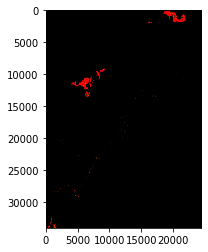

In [7]:
#model = load_model('C:\Data\BasicCNN_model.h5')
#model = tf.keras.models.load_model(b"C:\Data\BasicCNN_model.h5", compile = False)
model = tf.keras.models.load_model(b"C:\Data\BasicCNN_Full_5.h5")
#model = tf.saved_model.load(export_dir=r'C:\Data\model', tags=None, options=None) 
model.summary()
predictingNewX(model,data_dir_list,data_path,width=83,height=83,layers=7)
merge_raster_in_folder(output_path,result_path)

In [8]:
print(tf.__version__)

2.7.0
